In [10]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import numpy as np 
import pandas as pd

In [12]:
dataset_path = "./dataset.csv"
full = True

df = pd.read_csv(
    dataset_path,
    # dtype is specified to prevent a DtypeWarning
    dtype={
        "full_query": str,
        "label": int,
        "statement_type": str,
        "query_template_id": str,
        "attack_payload": str,
        "attack_id": str,
        "attack_technique": str,
        "attack_desc": str,
        "split": str,
        "sqlmap_status" : str,
        "attack_stage" : str,
    },
)


## Generic stats   


In [13]:
def display_counts_recon(df : pd.DataFrame):
    result = df.groupby('attack_id')['attack_stage'].value_counts().unstack(fill_value=0)
    
    if full:
        with pd.option_context('display.max_rows', None, 
                        'display.max_columns', None,
                        'display.width', None,
                        'display.max_colwidth', None):
            display(result)
    else: 
        display(result)

        
_ = display_counts_recon(df)


attack_stage,exploit,recon
attack_id,,
error-0,0,150
error-1,2,224
error-2,1,707
error-3,2,477
error-4,2,224
error-5,2,226
error-6,1,225
error-7,1,68
error-9,2,1981


In [14]:
def display_attack_normal_per_set(df : pd.DataFrame):
    df_train_atk = df[(df["label"] == 1) & (df["split"] == "train")]  
    df_train_normal = df[(df["label"] == 0) & (df["split"] == "train")]  

    df_test_atk = df[(df["label"] == 1) & (df["split"] == "test")]  
    df_test_normal = df[(df["label"] == 0) & (df["split"] == "test")]  

    print(f"Number of attacks in train: {df_train_atk.shape[0]}")
    print(f"Number of normal in train: {df_train_normal.shape[0]}")
    print(f"Number of attacks in test: {df_test_atk.shape[0]}")
    print(f"Number of normal in test: {df_test_normal.shape[0]}")

display_attack_normal_per_set(df)

Number of attacks in train: 2885
Number of normal in train: 2317
Number of attacks in test: 1410
Number of normal in test: 15541


In [15]:
def display_ids_per_set(df: pd.DataFrame):
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]

    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    tids_complement = set(tids_test) - set(tids_train)
    print(f"Template IDS in df train: {len(tids_train)}, {tids_train}")
    print(f"Template IDS in df test:   {len(tids_test)}, {tids_test}")
    print(
        f"Template IDs in test but NOT in train: {len(tids_complement)}, {tids_complement}"
    )

    # Compute which template only have normal queries
    df_n = df.loc[df["label"] == 0,"query_template_id"].unique()
    df_a = df.loc[df["label"] == 1,"query_template_id"].unique()

    print(f"Templates IDs with no attacks: {set(df_n) - set(df_a)}")


display_ids_per_set(df)

Template IDS in df train: 23, ['airport-U8' 'airport-I4' 'airport-S18' 'airport-S3' 'airport-S13'
 'airport-D8' 'airport-S16' 'airport-S21' 'airport-D7' 'airport-D5'
 'airport-S1' 'airport-S23' 'airport-admin8' 'airport-admin11'
 'airport-admin1' 'airport-admin10' 'airport-admin9' 'airport-admin14'
 'airport-admin13' 'airport-admin5' 'airport-admin7' 'airport-admin2'
 'airport-admin3']
Template IDS in df test:   29, ['airport-S23' 'airport-I4' 'airport-S1' 'airport-S19' 'airport-S4'
 'airport-D5' 'airport-U8' 'airport-S5' 'airport-S18' 'airport-S3'
 'airport-S13' 'airport-D8' 'airport-S16' 'airport-S21' 'airport-D7'
 'airport-admin12' 'airport-admin11' 'airport-admin3' 'airport-admin13'
 'airport-admin1' 'airport-admin10' 'airport-admin8' 'airport-admin2'
 'airport-admin6' 'airport-admin14' 'airport-admin9' 'airport-admin7'
 'airport-admin4' 'airport-admin5']
Template IDs in test but NOT in train: 6, {'airport-S19', 'airport-admin6', 'airport-S5', 'airport-admin4', 'airport-S4', 'airpo

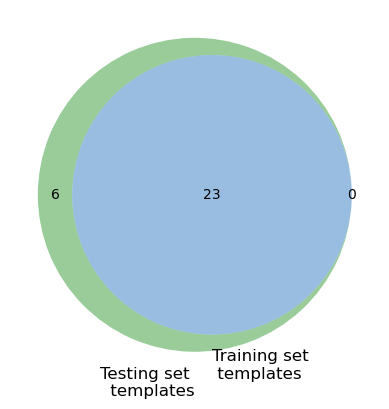

In [16]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

def plot_templates_in_sets(df : pd.DataFrame): 
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    
    tids_train = df_train["query_template_id"].unique()
    tids_test = df_test["query_template_id"].unique()
    venn2((set(tids_test),set(tids_train)), ("Testing set \n templates","Training set \n templates"),set_colors=("green","blue"))
    plt.show()

plot_templates_in_sets(df=df)

In [17]:
def _stmt_proportion(df: pd.DataFrame):
    return df['statement_type'].value_counts(normalize=True)

def display_ratio_per_stmt(df : pd.DataFrame):
    
    df_a = df[df["label"] == 1]
    df_n = df[df["label"] == 0]
    print(f"Proportion amongst normal: {_stmt_proportion(df=df_n)}")
    print(f"Proportion amongst attacks: {_stmt_proportion(df=df_a)}")
        
    df_train = df[df["split"] == "train"]
    df_test = df[df["split"] == "test"]
    print(f"Proportion amongst train: {_stmt_proportion(df=df_train)}")
    print(f"Proportion amongst test: {_stmt_proportion(df=df_test)}")

    dfntest = df_test[df_test["label"] == 0]

display_ratio_per_stmt(df=df)

Proportion amongst normal: statement_type
select    0.680087
update    0.108187
insert    0.104547
delete    0.097603
admin     0.009576
Name: proportion, dtype: float64
Proportion amongst attacks: statement_type
insert    0.461700
select    0.321071
update    0.111525
delete    0.105704
Name: proportion, dtype: float64
Proportion amongst train: statement_type
select    0.410035
insert    0.332564
update    0.133602
delete    0.118608
admin     0.005190
Name: proportion, dtype: float64
Proportion amongst test: statement_type
select    0.671996
insert    0.125066
update    0.101233
delete    0.093210
admin     0.008495
Name: proportion, dtype: float64


In [18]:
def print_stats_original(df : pd.DataFrame):
    df_og = df[df["template_split"] == "original"]
    df_chall = df[df["template_split"] == "challenging"]

    tids_og = df_og["query_template_id"].unique()
    tids_chall = df_chall["query_template_id"].unique()
    print(f"Template IDS in df original: {len(tids_og)}, {tids_og}")
    print(f"Template IDS in df challenging:   {len(tids_chall)}, {tids_chall}")
    
    print(f"Queries in original set: {len(df_og)}")
    df_a = df_og[df_og["label"] == 1]
    df_n = df_og[df_og["label"] == 0]
    print(f"Number of attacks in original: {df_a.shape[0]}")
    print(f"Number of normal in original: {df_n.shape[0]}")

    print(f"Queries in challenging set: {len(df_chall)}")
    df_a = df_chall[df_chall["label"] == 1]
    df_n = df_chall[df_chall["label"] == 0]
    print(f"Number of attacks in challenging: {df_a.shape[0]}")
    print(f"Number of normal in challenging: {df_n.shape[0]}")
print_stats_original(df=df)

Template IDS in df original: 26, ['airport-S23' 'airport-I4' 'airport-S1' 'airport-D5' 'airport-U8'
 'airport-S18' 'airport-S3' 'airport-S13' 'airport-D8' 'airport-S16'
 'airport-S21' 'airport-D7' 'airport-admin12' 'airport-admin11'
 'airport-admin3' 'airport-admin13' 'airport-admin1' 'airport-admin10'
 'airport-admin8' 'airport-admin2' 'airport-admin6' 'airport-admin14'
 'airport-admin9' 'airport-admin5' 'airport-admin7' 'airport-admin4']
Template IDS in df challenging:   3, ['airport-S19' 'airport-S4' 'airport-S5']
Queries in original set: 17358
Number of attacks in original: 4076
Number of normal in original: 13282
Queries in challenging set: 4795
Number of attacks in challenging: 219
Number of normal in challenging: 4576
